# Определение возраста покупателей

Описание проекта

Тема: Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Инструкция по выполнению проекта:
- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
print('Размерность всей выборки составляет:', labels.shape)

Размерность всей выборки составляет: (7591, 2)


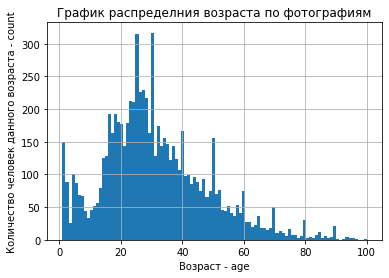

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64


In [4]:
labels.real_age.hist(bins=100)
plt.xlabel('Возраст - age')
plt.ylabel('Количество человек данного возраста - count')
plt.title('График распределния возраста по фотографиям')
plt.show()
print(labels.real_age.describe())

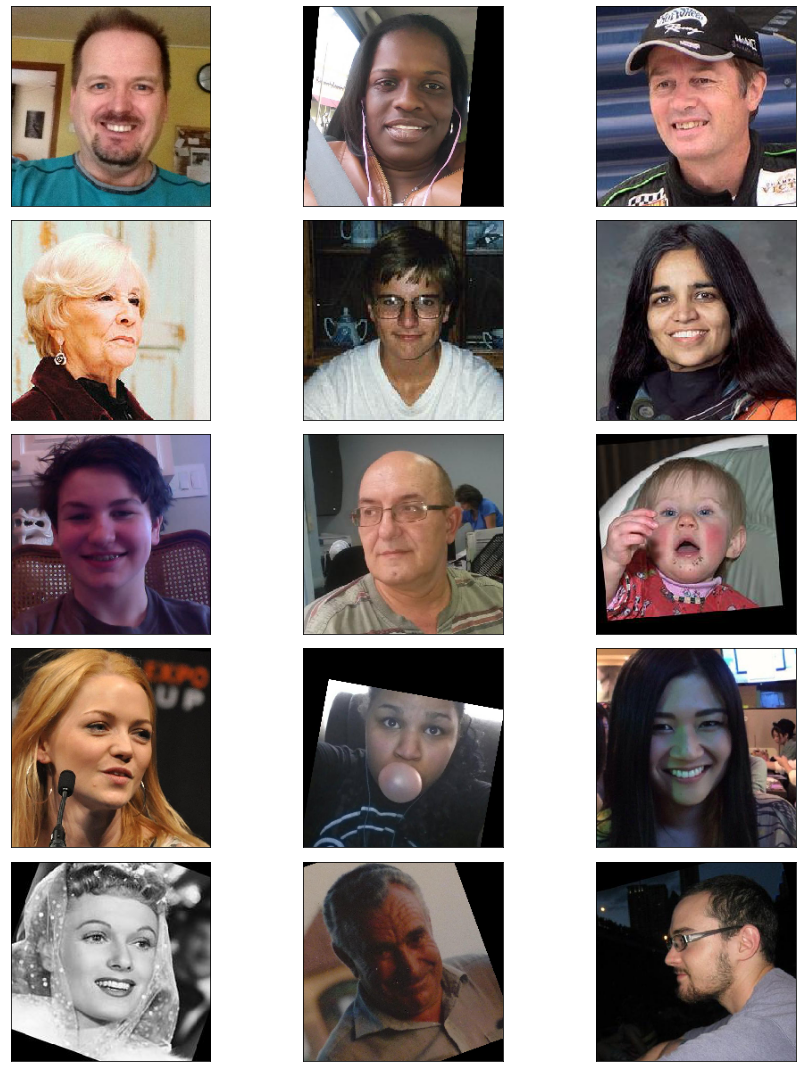

In [6]:
X, y = next(train_gen_flow)

fig = plt.figure(figsize=(15, 15))
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(X[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Размер выборки составляет 7591 фотографию. Из построенного графика по возрасту видно, что основная масса фотографий составляет возраст людей от 20 до 41 года. В датасете присутствуют фотографии в цветном и черно-белом варианте, также есть повернутые фотографии относительно нормального расположения. Также на фото есть сторонние предметы, например микрофон, очки и т.п.. Также присутствует разная фокусировка изображений, где то только лица, а где то захвачен в большом объёме задний фон.

## Обучение модели

**Данный код выполнялся на отдельно выделенном ресурсе, так что представлен только код выполнения.**

```

#код загрузки и обучения модели

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                 directory=path + 'final_files/',
                                                 x_col='file_name',
                                                 y_col='real_age',
                                                 target_size=(224, 224),
                                                 batch_size=16,
                                                 class_mode='raw',
                                                 subset='training',
                                                 seed=12345)
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(dataframe=labels,
                                                directory=path + 'final_files/',
                                                x_col='file_name',
                                                y_col='real_age',
                                                target_size=(224, 224),
                                                batch_size=16,
                                                class_mode='raw',
                                                subset='validation',
                                                seed=12345)
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=4,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
    
```

```

#вывод информации по ходу обучения модели

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 7s
   90112/94765736 [..............................] - ETA: 56s
  270336/94765736 [..............................] - ETA: 38s
  802816/94765736 [..............................] - ETA: 18s
 2113536/94765736 [..............................] - ETA: 9s 
 4038656/94765736 [>.............................] - ETA: 5s
 9011200/94765736 [=>............................] - ETA: 2s
13303808/94765736 [===>..........................] - ETA: 2s
18120704/94765736 [====>.........................] - ETA: 1s
22478848/94765736 [======>.......................] - ETA: 1s
27230208/94765736 [=======>......................] - ETA: 1s
31719424/94765736 [=========>....................] - ETA: 1s
36298752/94765736 [==========>...................] - ETA: 1s
40984576/94765736 [===========>..................] - ETA: 0s
45400064/94765736 [=============>................] - ETA: 0s
50102272/94765736 [==============>...............] - ETA: 0s
54460416/94765736 [================>.............] - ETA: 0s
59342848/94765736 [=================>............] - ETA: 0s
62676992/94765736 [==================>...........] - ETA: 0s
66904064/94765736 [====================>.........] - ETA: 0s
71811072/94765736 [=====================>........] - ETA: 0s
75276288/94765736 [======================>.......] - ETA: 0s
79642624/94765736 [========================>.....] - ETA: 0s
84197376/94765736 [=========================>....] - ETA: 0s
87982080/94765736 [==========================>...] - ETA: 0s
92217344/94765736 [============================>.] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 356 steps, validate for 119 steps
Epoch 1/4
2023-04-28 21:03:50.309191: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-28 21:03:50.864610: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 54s - loss: 209.5863 - mae: 10.4603 - val_loss: 782.0360 - val_mae: 22.9463
Epoch 2/4
356/356 - 47s - loss: 83.2273 - mae: 6.9162 - val_loss: 108.9903 - val_mae: 7.7929
Epoch 3/4
356/356 - 48s - loss: 57.1247 - mae: 5.7809 - val_loss: 103.2824 - val_mae: 8.0003
Epoch 4/4
356/356 - 38s - loss: 42.7368 - mae: 4.9816 - val_loss: 90.1674 - val_mae: 6.9921

119/119 - 9s - loss: 90.1674 - mae: 6.9921
Test MAE: 6.9921

```

## Анализ обученной модели

В данной работе была рассмотрена модель для определения приблизительного возраста покупателей. Путем подбора параметров модели получили MAE равный 6.9921. 
Данный показатель MAE был достигнут при таких параметрах:
- количестве эпох равный 4;
- использовали параметра функции потерь - среднеквадратичная ошибка;
- использовали оптимизируемый параметр Adam со скоростью обучения 0.0001;
- воспользовались ResNet50;
- использовали слой GlobalAveragePooling2D;
- использовали слой Dense, с активатором relu.

Для анализа покупаемых товаров и предложений, которые могут заинтересовать определенную возрастную группу покупателей, данная модель должна показать себя хорошо. 

Однако со второй задачей, контролем добросовестности кассиров при продаже алкогольной продукции, следует учесть достаточную среднеквадратичную ошибку около 7, что может сказаться на неправильной оценке при продаже алкогольной продукции.